# SETUP

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm

import lightgbm as lgb
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

%matplotlib inline

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load Data

In [2]:
# load
data_A_raw = pd.read_pickle('C:/Users/ewpadmin/JIHYUN/aaa.pkl')
data_B_raw = pd.read_pickle('C:/Users/ewpadmin/JIHYUN/bbb.pkl')
data_C_raw = pd.read_pickle('C:/Users/ewpadmin/JIHYUN/ccc.pkl')

In [3]:
data_A_raw.columns

Index(['time', 'solar1', 'solar2', 'real_time_power', 'day_power', 'month',
       'day', 'hour', 'minute', 'temperature_3H', 'sky',
       'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed',
       'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132'],
      dtype='object')

In [4]:
data_A_raw.describe()

,real_time_power,day_power,temperature_3H,sky,rainfall_probability,rainfall,snow,humidity,wind_speed,Elevation_angle,Azimuth_angle,dust_132
count,42713.000000,42713.000000,42713.000000,42713.000000,42713.000000,42713.000000,42713.000000,42713.000000,42713.000000,42713.000000,42713.000000,42713.000000
mean,544.011777,5954.096686,14.460108,2.559314,20.061223,0.343923,0.005057,80.400147,3.905821,0.393821,180.146801,33.232075
std,853.417460,6809.524830,10.397669,1.029941,19.550291,2.807970,0.104731,15.229133,2.497544,37.449318,100.426537,28.545716
min,0.000000,0.000000,-9.000000,1.000000,0.000000,0.000000,0.000000,25.000000,0.100000,-76.400000,0.030000,-158.250273
25%,0.000000,0.000000,5.750000,2.000000,10.000000,0.000000,0.000000,70.000000,2.125000,-30.270000,89.730000,17.805356
50%,0.000000,2573.661000,15.750000,2.833333,18.333333,0.000000,0.000000,85.000000,3.300000,0.720000,179.910000,26.447605
75%,843.779236,11969.090000,23.833333,3.083333,20.833333,0.000000,0.000000,94.583333,4.966667,30.670000,270.460000,40.357820
max,3433.908203,23119.360000,35.000000,4.000000,90.000000,70.000000,5.000000,100.000000,23.900000,76.350000,359.960000,493.000000


In [19]:
data_A_raw.dtypes

time                    datetime64[ns]
solar1                          object
solar2                          object
real_time_power                float64
day_power                      float64
month                         category
day                           category
hour                          category
minute                        category
temperature_3H                 float64
sky                            float64
rainfall_probability           float64
rainfall                       float64
snow                           float64
humidity                       float64
wind_speed                     float64
wind_direction                category
Elevation_angle                float64
Azimuth_angle                  float64
dust_132                       float64
dtype: object

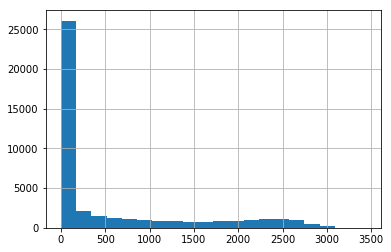

In [7]:
data_A_raw.real_time_power.hist(bins=20)

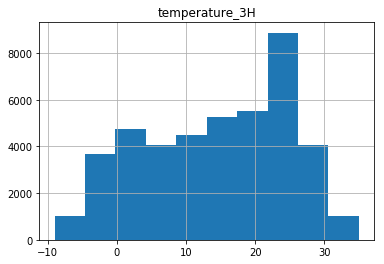

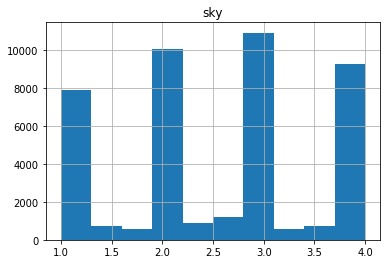

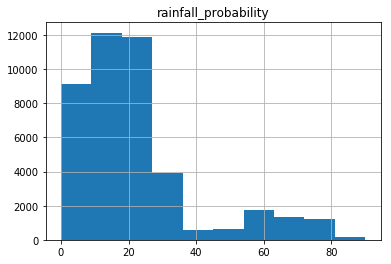

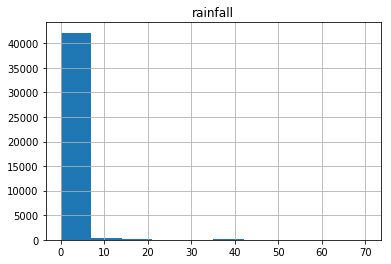

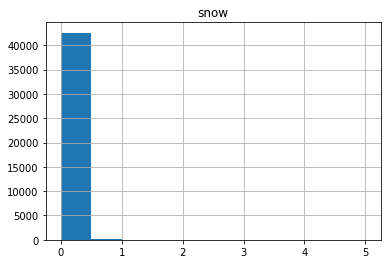

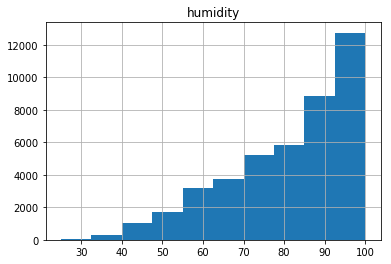

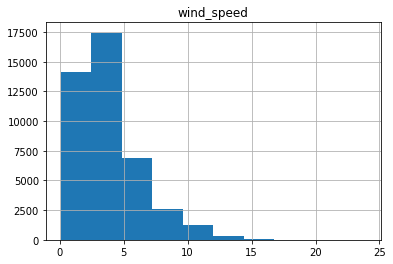

In [21]:
# data 별 분포

for column in data_A_raw.columns[9:16]:
    data_A_raw[column].hist()
    plt.title(column)
    plt.show()

# 일사량, 태양광 비교(2019 1, 2월)

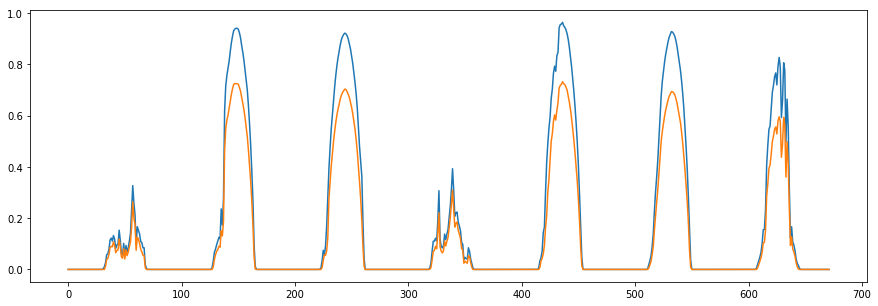

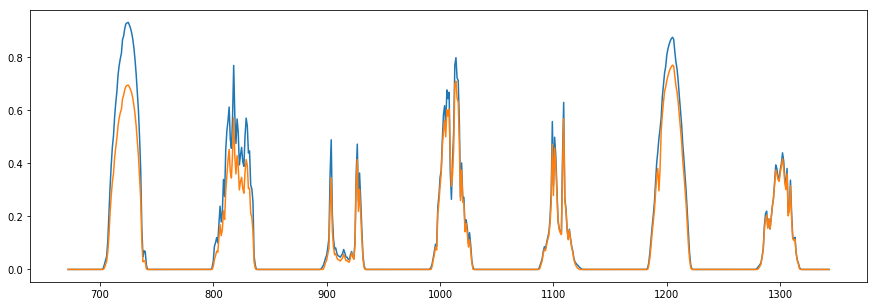

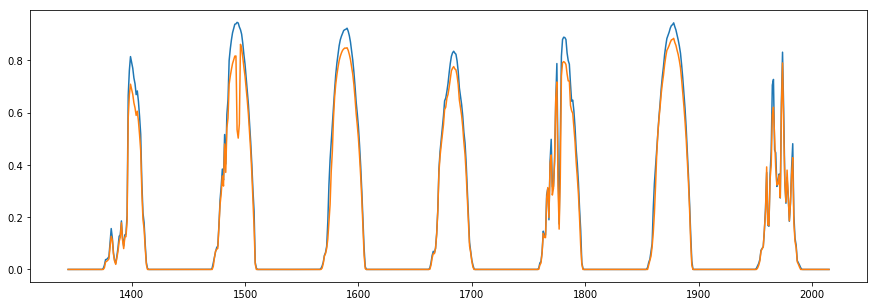

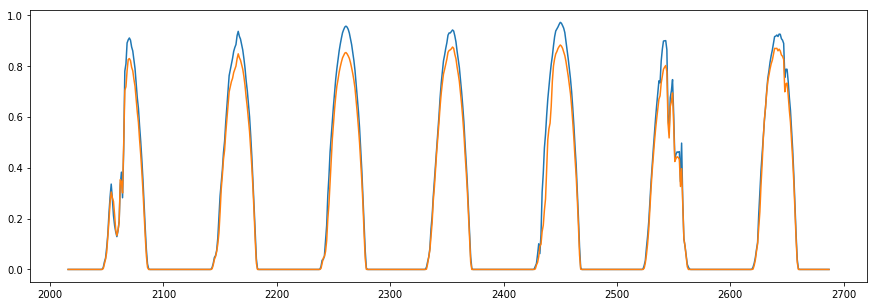

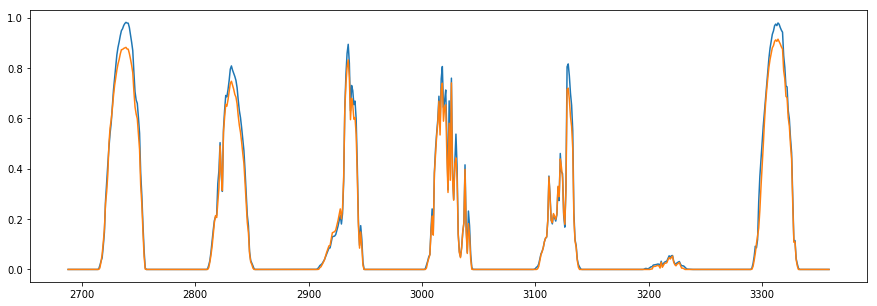

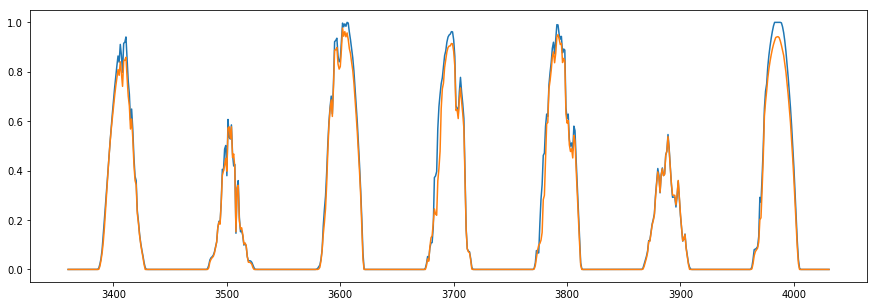

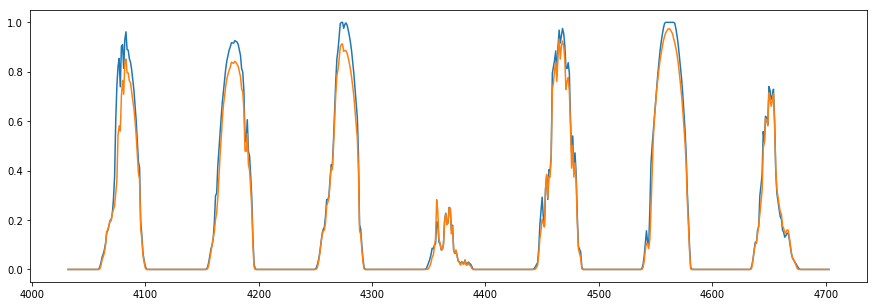

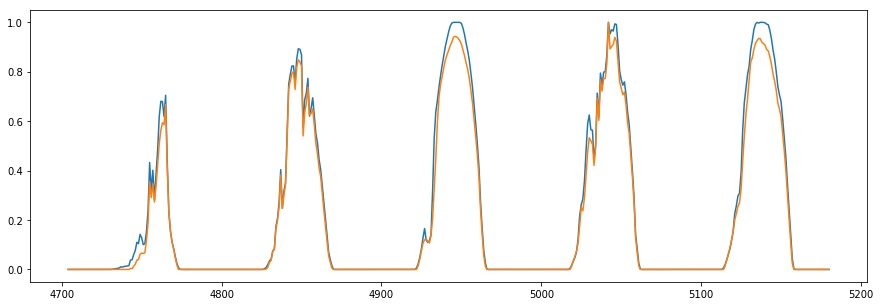

In [24]:
# slicing
data_A_raw = data_A_raw.iloc[-5181:, :]
data_B_raw = data_B_raw.iloc[-5181:, :]
data_C_raw = data_C_raw.iloc[-5181:, :]

# solar
data_solar_concat = pd.DataFrame(columns=['A_Site', 'B_Site', 'C_Site'])
data_solar_concat['A_Site'] = data_A_raw.solar1.values
data_solar_concat['B_Site'] = data_B_raw.solar1.values
data_solar_concat['C_Site'] = data_C_raw.solar1.values

# power
data_power_concat = pd.DataFrame(columns=['A_Site', 'B_Site', 'C_Site'])
data_power_concat['A_Site'] = data_A_raw.real_time_power.values
data_power_concat['B_Site'] = data_B_raw.real_time_power.values
data_power_concat['C_Site'] = data_C_raw.real_time_power.values

# scaling
mms = MinMaxScaler()

data_solar_concat_sc = mms.fit_transform(data_solar_concat)
data_solar_concat = pd.DataFrame(data=data_solar_concat_sc, columns=data_solar_concat.columns)

data_power_concat_sc = mms.fit_transform(data_power_concat)
data_power_concat = pd.DataFrame(data=data_power_concat_sc, columns=data_power_concat.columns)

n = 0
m = 7
for n in [24*4*m*i for i in range(8)]:
    plt.figure(figsize=(15, 5))
    data_solar_concat.iloc[n:n+24*4*m].A_Site.plot()
    data_power_concat.iloc[n:n+24*4*m].A_Site.plot()
    plt.show()

---

# 풍향(북서풍 = 7)에 따른 풍속-현재 전력 상관관계

In [24]:
data_test = data_A_raw[data_A_raw.wind_direction == 7]
data_test = data_test[data_test.real_time_power > 5]
data_test = data_test[data_test.wind_speed > 7]
data_test.corr()

,real_time_power,day_power,temperature_3H,sky,rainfall_probability,rainfall,snow,humidity,wind_speed,Elevation_angle,Azimuth_angle,dust_132
real_time_power,1.000000,0.456332,-0.344236,-0.455385,-0.451472,0.267970,-0.093458,-0.174952,-0.135168,0.572406,0.133948,0.162700
day_power,0.456332,1.000000,-0.348928,-0.171260,-0.197612,0.043970,-0.139480,-0.041278,-0.275076,-0.006217,0.726021,-0.033248
temperature_3H,-0.344236,-0.348928,1.000000,0.194902,0.304664,0.047663,0.023243,0.552636,-0.004153,0.015517,-0.155805,-0.038442
sky,-0.455385,-0.171260,0.194902,1.000000,0.953066,-0.320869,-0.190643,0.376827,0.189641,0.081958,0.212568,-0.307616
rainfall_probability,-0.451472,-0.197612,0.304664,0.953066,1.000000,-0.290860,-0.171980,0.460496,0.234559,0.122786,0.169646,-0.317404
rainfall,0.267970,0.043970,0.047663,-0.320869,-0.290860,1.000000,0.295518,-0.114436,-0.009775,0.101897,-0.087546,-0.024244
snow,-0.093458,-0.139480,0.023243,-0.190643,-0.171980,0.295518,1.000000,-0.061712,-0.203391,-0.138941,-0.204431,-0.094910
humidity,-0.174952,-0.041278,0.552636,0.376827,0.460496,-0.114436,-0.061712,1.000000,-0.220812,0.281456,0.265406,-0.150845
wind_speed,-0.135168,-0.275076,-0.004153,0.189641,0.234559,-0.009775,-0.203391,-0.220812,1.000000,0.016805,-0.133293,-0.092449
Elevation_angle,0.572406,-0.006217,0.015517,0.081958,0.122786,0.101897,-0.138941,0.281456,0.016805,1.000000,0.037703,-0.060688


In [25]:
data_test.describe()

,real_time_power,day_power,temperature_3H,sky,rainfall_probability,rainfall,snow,humidity,wind_speed,Elevation_angle,Azimuth_angle,dust_132
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,1228.608937,4846.823750,-2.068786,2.088393,11.495889,0.531784,0.097723,60.267236,9.416271,23.878008,179.249469,59.752057
std,1008.838701,5027.373064,2.341816,0.955799,11.190955,1.733050,0.584817,12.469481,1.581944,10.384314,39.663208,40.162035
min,5.022137,0.053264,-7.333333,1.000000,0.000000,0.000000,0.000000,35.000000,7.008333,-0.210000,108.080000,11.633794
25%,222.337649,523.062597,-3.625000,1.000000,0.000000,0.000000,0.000000,52.291667,7.933333,15.690000,144.945000,32.966188
50%,1034.259379,2725.658536,-2.500000,2.000000,10.000000,0.000000,0.000000,58.333333,9.500000,26.200000,179.010000,45.000000
75%,2240.579349,8172.662171,-0.583333,3.000000,20.000000,0.000000,0.000000,65.416667,10.500000,32.055000,215.085000,76.577124
max,3061.384167,17172.520274,5.000000,4.000000,60.000000,10.000000,5.000000,97.500000,13.800000,41.580000,252.920000,196.000000


In [26]:
data_test

,time,solar1,solar2,real_time_power,day_power,month,day,hour,minute,temperature_3H,sky,rainfall_probability,rainfall,snow,humidity,wind_speed,wind_direction,Elevation_angle,Azimuth_angle,dust_132
37565,2019-01-01 08:15:00,26.7324,25.0016,38.688497,3.328467,1,1,8,15,-2.250000,2.250000,12.500000,0.000000,0.000000,62.500000,9.775000,7,4.12,122.91,24.689328
37566,2019-01-01 08:30:00,57.2352,51.3305,122.827122,21.432092,1,1,8,30,-2.500000,2.166667,11.666667,0.000000,0.000000,63.333333,9.816667,7,6.54,125.32,22.994547
37567,2019-01-01 08:45:00,61.2055,54.1089,132.614799,56.176882,1,1,8,45,-2.750000,2.083333,10.833333,0.000000,0.000000,64.166667,9.858333,7,8.91,127.81,21.802493
37568,2019-01-01 09:00:00,77.7824,76.5653,181.477539,90.784760,1,1,9,0,-3.000000,2.000000,10.000000,0.000000,0.000000,65.000000,9.900000,7,11.21,130.40,23.000000
37569,2019-01-01 09:15:00,115.18,104.271,268.044473,149.092972,1,1,9,15,-3.000000,2.083333,10.833333,0.000000,0.000000,64.583333,9.908333,7,13.43,133.09,26.587068
37570,2019-01-01 09:30:00,122.225,116.508,282.799530,214.016505,1,1,9,30,-3.000000,2.166667,11.666667,0.000000,0.000000,64.166667,9.916667,7,15.56,135.89,32.563696
37571,2019-01-01 09:45:00,110.617,108.199,276.640085,285.327429,1,1,9,45,-3.000000,2.250000,12.500000,0.000000,0.000000,63.750000,9.925000,7,17.58,138.80,38.258477
37572,2019-01-01 10:00:00,132.245,125.074,337.652374,365.740952,1,1,10,0,-3.000000,2.333333,13.333333,0.000000,0.000000,63.333333,9.933333,7,19.49,141.83,41.000000
37573,2019-01-01 10:15:00,117.9,114.442,288.850065,440.779560,1,1,10,15,-3.000000,2.416667,14.166667,0.000000,0.000000,62.916667,9.941667,7,21.27,144.98,40.788266
37574,2019-01-01 10:30:00,82.4215,86.0227,203.663910,503.749724,1,1,10,30,-3.000000,2.500000,15.000000,0.000000,0.000000,62.500000,9.950000,7,22.91,148.25,37.623275


---

# 기상예보데이터 매핑

In [4]:
data_forecast = pd.read_pickle('data_forecast_final_02.pkl')
data_forecast.index = data_forecast.time
data_forecast.drop('time', axis=1, inplace=True)
data_revise = data_forecast.resample('15min').interpolate(method='quadratic')
data_revise.reset_index(inplace=True)
data_revise.tail()

,time,temperature_3H,sky,rainfall_probability,rainfall,snow,humidity,wind_speed,wind_direction
78896,2019-01-01 08:00:00,-1.482848,2.646518,16.465177,0.0,0.0,59.970882,9.805710,304.590926
78897,2019-01-01 08:15:00,-1.813653,2.514249,15.142493,0.0,0.0,61.069181,9.836068,304.467344
78898,2019-01-01 08:30:00,-2.176780,2.362407,13.624069,0.0,0.0,62.273468,9.861902,304.327662
78899,2019-01-01 08:45:00,-2.572229,2.190990,11.909905,0.0,0.0,63.583741,9.883213,304.171881
78900,2019-01-01 09:00:00,-3.000000,2.000000,10.000000,0.0,0.0,65.000000,9.900000,304.000000


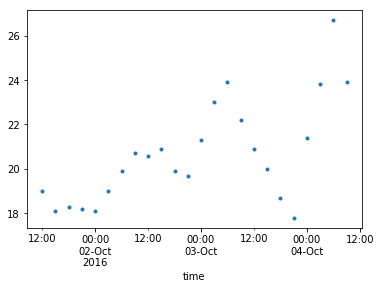

In [5]:
data_forecast.temperature_3H[:24].plot(style='.')

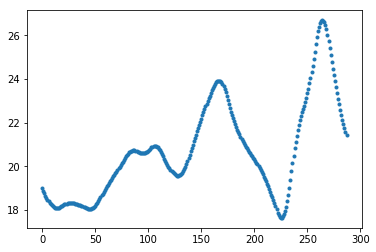

In [6]:
data_revise.temperature_3H[:288].plot(style='.')

In [7]:
data_power = pd.read_pickle('C:/Users/ewpadmin/EWP_HSY/A_site_solar_Data_concat_06.pkl')
data_power.columns = ['time', 'solar1', 'solar2', 'real_time_power', 'day_power']
data_power.tail()

,time,solar1,solar2,real_time_power,day_power
5850,2018-12-31 22:45:00,0,0,0,10572.3
5851,2018-12-31 23:00:00,0,0,0,10572.3
5852,2018-12-31 23:15:00,0,0,0,10572.3
5853,2018-12-31 23:30:00,0,0,0,10572.3
5854,2018-12-31 23:45:00,0,0,0,8131.68


In [8]:
data_merge = pd.merge(data_revise, data_power, on='time')
data_merge.tail()

,time,temperature_3H,sky,rainfall_probability,rainfall,snow,humidity,wind_speed,wind_direction,solar1,solar2,real_time_power,day_power
37527,2018-12-31 22:45:00,-2.101791,2.744467,17.444673,0.0,0.0,78.470863,7.362852,314.159012,0,0,0,10572.3
37528,2018-12-31 23:00:00,-2.097698,2.845088,18.450882,0.0,0.0,77.974681,7.434546,313.514041,0,0,0,10572.3
37529,2018-12-31 23:15:00,-2.085472,2.920952,19.209520,0.0,0.0,77.379504,7.504108,312.875654,0,0,0,10572.3
37530,2018-12-31 23:30:00,-2.065114,2.972059,19.720585,0.0,0.0,76.685332,7.571538,312.243852,0,0,0,10572.3
37531,2018-12-31 23:45:00,-2.036623,2.998408,19.984079,0.0,0.0,75.892164,7.636835,311.618634,0,0,0,8131.68


In [9]:
print(data_merge.dtypes)
data_merge[['solar1', 'solar2', 'real_time_power', 'day_power']] = data_merge[['solar1', 'solar2', 'real_time_power', 'day_power']].astype(np.float64)
print(data_merge.dtypes)

time                    datetime64[ns]
temperature_3H                 float64
sky                            float64
rainfall_probability           float64
rainfall                       float64
snow                           float64
humidity                       float64
wind_speed                     float64
wind_direction                 float64
solar1                          object
solar2                          object
real_time_power                 object
day_power                       object
dtype: object
time                    datetime64[ns]
temperature_3H                 float64
sky                            float64
rainfall_probability           float64
rainfall                       float64
snow                           float64
humidity                       float64
wind_speed                     float64
wind_direction                 float64
solar1                         float64
solar2                         float64
real_time_power                float64
day_power  

# 변수 간 상관관계 분석

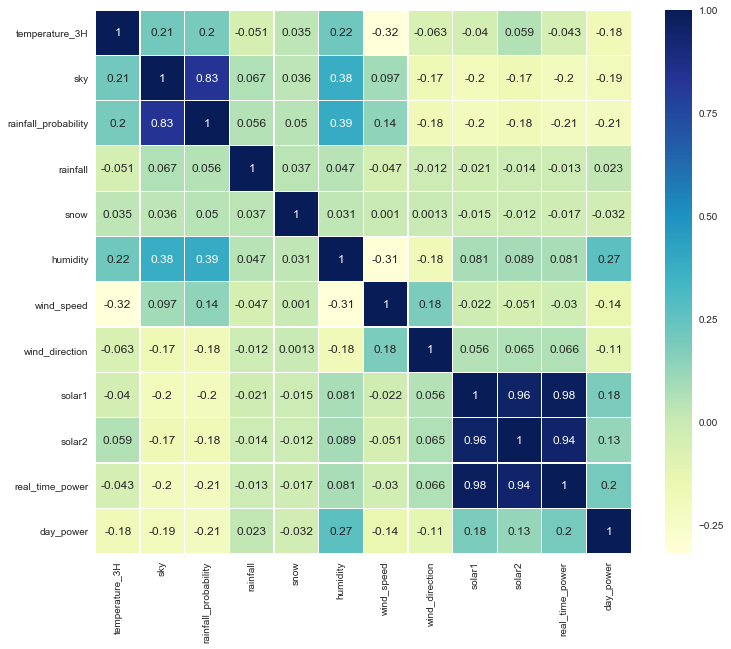

In [12]:
import seaborn as sns
sns.set()

data_corr = data_merge.iloc[:, 1:].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(data_corr, annot=True, linewidths=.2, cmap='YlGnBu')

---

# 기상 실측 데이터-기상 예보 데이터 비교

In [13]:
data_weather = pd.read_pickle('C:/Users/ewpadmin/JDY/df_temp_dropna_0208.pkl')
data_weather.reset_index(drop=True, inplace=True)
data_weather = data_weather.iloc[:, :6]
data_weather.columns = ['time', 'temperature_act', 'rainfall_act', 'wind_direction_act', 'wind_speed_act', 'humidity_act']
data_weather.tail()

,time,temperature_act,rainfall_act,wind_direction_act,wind_speed_act,humidity_act
37247,2018-12-31 22:45:00,-2.2,0.0,북풍,0.6,71.5
37248,2018-12-31 23:00:00,-2.1,0.0,북풍,0.2,71.5
37249,2018-12-31 23:15:00,-1.3,0.0,북풍,2.3,66.8
37250,2018-12-31 23:30:00,-1.1,0.0,북풍,2.9,63.7
37251,2018-12-31 23:45:00,-1.4,0.0,북풍,2.2,64.0


In [14]:
data_merge = pd.merge(data_revise, data_weather, on='time')
data_merge.tail()

,time,temperature_3H,sky,rainfall_probability,rainfall,snow,humidity,wind_speed,wind_direction,temperature_act,rainfall_act,wind_direction_act,wind_speed_act,humidity_act
37194,2018-12-31 22:45:00,-2.101791,2.744467,17.444673,0.0,0.0,78.470863,7.362852,314.159012,-2.2,0.0,북풍,0.6,71.5
37195,2018-12-31 23:00:00,-2.097698,2.845088,18.450882,0.0,0.0,77.974681,7.434546,313.514041,-2.1,0.0,북풍,0.2,71.5
37196,2018-12-31 23:15:00,-2.085472,2.920952,19.209520,0.0,0.0,77.379504,7.504108,312.875654,-1.3,0.0,북풍,2.3,66.8
37197,2018-12-31 23:30:00,-2.065114,2.972059,19.720585,0.0,0.0,76.685332,7.571538,312.243852,-1.1,0.0,북풍,2.9,63.7
37198,2018-12-31 23:45:00,-2.036623,2.998408,19.984079,0.0,0.0,75.892164,7.636835,311.618634,-1.4,0.0,북풍,2.2,64.0


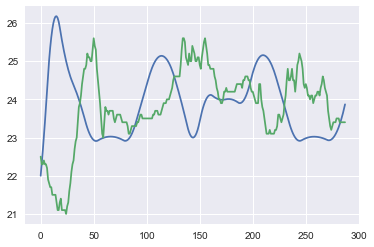

In [15]:
data_merge.temperature_3H[:288].plot()
data_merge.temperature_act[:288].plot()

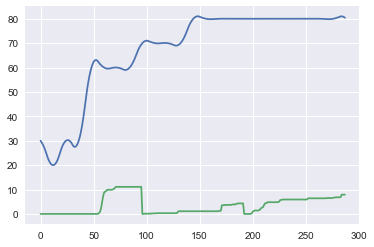

In [16]:
data_merge.rainfall_probability[:288].plot()
data_merge.rainfall_act[:288].plot()

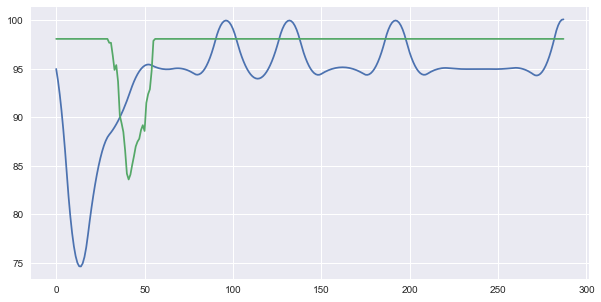

In [17]:
plt.figure(figsize=(10, 5))
data_merge.humidity[:288].plot()
data_merge.humidity_act[:288].plot()